In [1]:
import os
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models import convnext_large, ConvNeXt_Large_Weights
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


 #### Parameters

In [2]:
# Define constants
W, H = 224, 224
batch_size = 32
n_epoch = 50
drop_rate = 0.5

train_image_directory = 'Cat-Emotions-1/train'
valid_image_directory = 'Cat-Emotions-1/valid'


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


 #### Classes

In [4]:
class_names = [name for name in os.listdir(train_image_directory) if os.path.isdir(os.path.join(train_image_directory, name))]
class_names_label = {name: i for i, name in enumerate(class_names)}
print("Class Names:", class_names)
print("Class Names Labels:", class_names_label)


Class Names: ['Scared', 'Sad', 'Disgusted', 'Happy', 'Angry', 'Normal', 'Surprised']
Class Names Labels: {'Scared': 0, 'Sad': 1, 'Disgusted': 2, 'Happy': 3, 'Angry': 4, 'Normal': 5, 'Surprised': 6}


 ##### Plot a batch of images

In [5]:
def show_images(images, labels):

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    grid_img = make_grid(images, nrow=8)
    grid_img = grid_img.numpy().transpose((1, 2, 0))
    grid_img = std * grid_img + mean
    grid_img = np.clip(grid_img, 0, 1)

    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(grid_img)
    plt.show()


 #### Transformation for the training and valid

 added a horizontal flip for the training data

In [6]:
# Transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop((H, W), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_image_directory, transform=transform_train)
valid_dataset = datasets.ImageFolder(valid_image_directory, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


 ##### Plot a batch of images

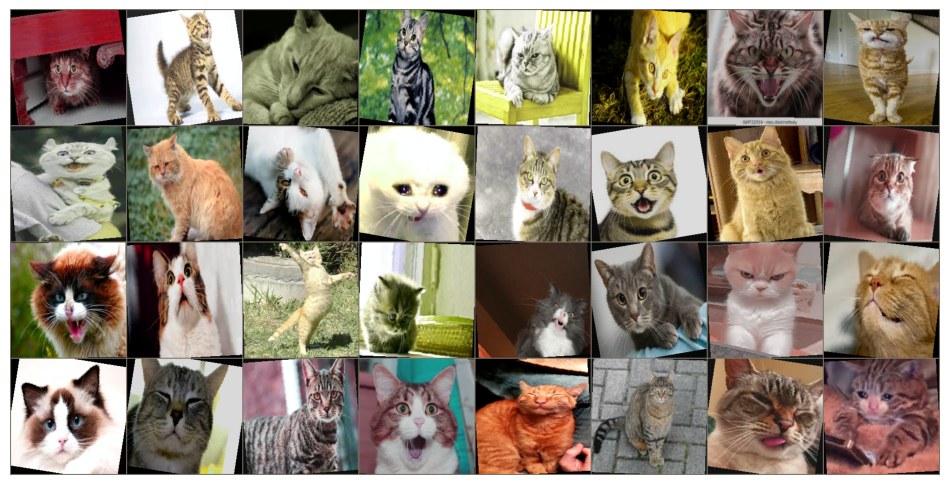

In [7]:
# Visualize some training images
images, labels = next(iter(train_loader))
show_images(images, labels)


 ##### Optimizer and model loading (ResNet50 - Fine-tuning)

 using cross entropy loss and ReduceLROnPlateau scheduler

In [8]:
from torchvision.models import resnet50, ResNet50_Weights
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# unfreeze all model parameters
for param in model.parameters():
    param.requires_grad = True

num_classes = len(class_names)
model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=drop_rate),
    nn.Linear(512, num_classes)
)

model = model.to(device)
criterion = nn.CrossEntropyLoss()

# Separate parameters for different learning rates
fc_params = list(model.fc.parameters())
backbone_params = [p for n, p in model.named_parameters() if "fc" not in n]

optimizer = optim.Adam([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': fc_params, 'lr': 1e-4}
])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)



 #### Training and validation loops

In [9]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=5):
    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        val_epoch_loss = val_running_loss / len(valid_loader.dataset)
        val_epoch_acc = val_running_corrects / len(valid_loader.dataset)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        scheduler.step(val_epoch_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    return train_acc, val_acc, train_loss, val_loss


 #### Training loss, accuracy and confusion matrix plots

In [10]:
def plot_metrics(train_acc,val_acc,train_loss,val_loss):
    plt.figure(1, figsize=(15, 8))

    plt.subplot(221)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(222)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_confusion_matrix(model, valid_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(valid_dataset.classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


In [11]:
train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=n_epoch)


Epoch 1/50, Train Loss: 1.9365, Train Acc: 0.1952, Val Loss: 1.9640, Val Acc: 0.0947
Epoch 2/50, Train Loss: 1.8903, Train Acc: 0.2331, Val Loss: 1.9515, Val Acc: 0.1006
Epoch 3/50, Train Loss: 1.8343, Train Acc: 0.2729, Val Loss: 1.9342, Val Acc: 0.1361
Epoch 4/50, Train Loss: 1.7522, Train Acc: 0.3566, Val Loss: 1.8913, Val Acc: 0.1775
Epoch 5/50, Train Loss: 1.6651, Train Acc: 0.4143, Val Loss: 1.8210, Val Acc: 0.2781
Epoch 6/50, Train Loss: 1.5225, Train Acc: 0.5398, Val Loss: 1.7121, Val Acc: 0.3728
Epoch 7/50, Train Loss: 1.4048, Train Acc: 0.5737, Val Loss: 1.6321, Val Acc: 0.4024
Epoch 8/50, Train Loss: 1.2639, Train Acc: 0.6355, Val Loss: 1.4978, Val Acc: 0.5207
Epoch 9/50, Train Loss: 1.1618, Train Acc: 0.6773, Val Loss: 1.4168, Val Acc: 0.5385
Epoch 10/50, Train Loss: 1.0170, Train Acc: 0.7131, Val Loss: 1.3353, Val Acc: 0.5680
Epoch 11/50, Train Loss: 0.9669, Train Acc: 0.6992, Val Loss: 1.2644, Val Acc: 0.5858
Epoch 12/50, Train Loss: 0.8753, Train Acc: 0.7430, Val Loss: 1

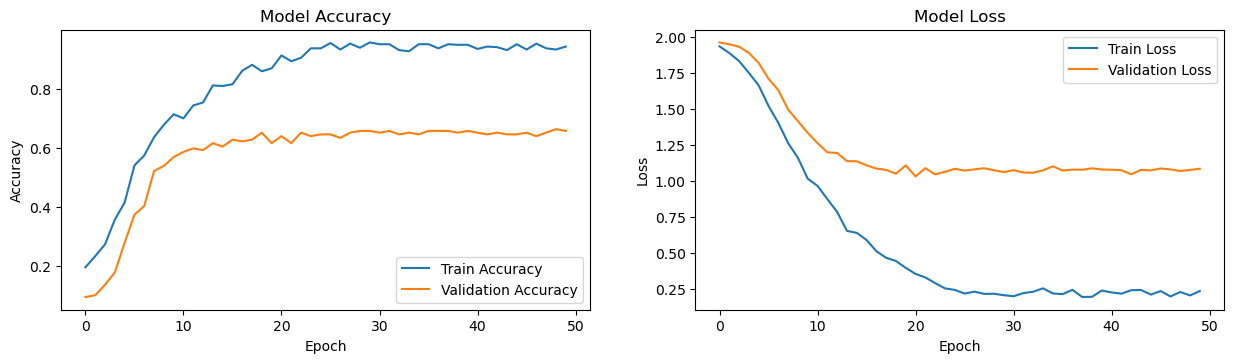

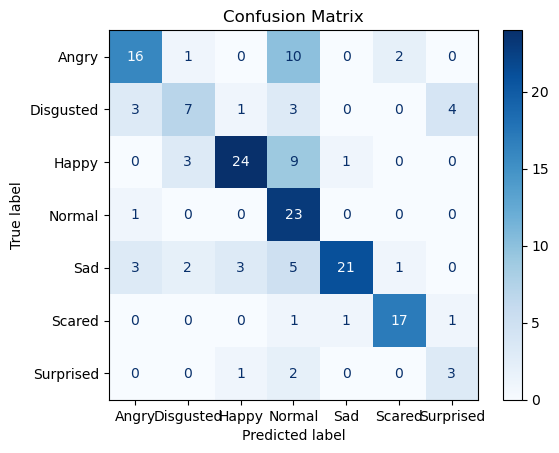

In [12]:
plot_metrics(train_acc,val_acc,train_loss,val_loss)
plot_confusion_matrix(model,valid_loader)
